In [1]:
#!pip install pandas_profiling

In [2]:
#!pip install markupsafe==2.0.1

In [1]:
# import libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

### Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline

### Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from pandas_profiling import ProfileReport

### Data Standardization and Modeling with PCA, Kmeans ++ , Gaussian Mixture (GMM) and BIRCH 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import  Birch 
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
df = pd.read_csv('C:/Users/elfek/Desktop/NTT/clean/customer_unique_id_rfm_red.csv', index_col=0, encoding='latin-1')

In [3]:
raw = df.copy()

In [4]:
df.columns

Index(['new_diff', 'customer_autonomous_community', 'customer_city',
       'payment_method', 'transaction_value', 'payment_method_sequence_id',
       'og_cat_combined', 'new_cat_combined', 'tot_spending', 'max_shipping',
       'tot_order_item_count', 'installment_payment', 'del/rev_mean',
       'rev_count/tot_items_mean', 'Frequency', 'tenure', 'Recency',
       'tot_ship/tot_spend'],
      dtype='object')

In [5]:
del df['transaction_value']
del df['og_cat_combined']
del df['new_cat_combined']
del df['payment_method_sequence_id']
del df['customer_city']

In [6]:
#Here we are going to transform the 4 payment method that we have (credit/debit/cash/voucher) into binary variables
#The encoding is to binary, and that is because one customer can pay in more than method. We are taking that into consideration

df = pd.concat([df.drop('payment_method', 1), df['payment_method'].str.get_dummies(sep=",")], 1)

C:\Users\elfek\AppData\Local\Temp/ipykernel_18472/2394200557.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df.drop('payment_method', 1), df['payment_method'].str.get_dummies(sep=",")], 1)
C:\Users\elfek\AppData\Local\Temp/ipykernel_18472/2394200557.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df = pd.concat([df.drop('payment_method', 1), df['payment_method'].str.get_dummies(sep=",")], 1)


In [7]:
df.describe()

,new_diff,tot_spending,max_shipping,tot_order_item_count,installment_payment,del/rev_mean,rev_count/tot_items_mean,Frequency,tenure,Recency,tot_ship/tot_spend,cash,credit_card,debit_card,voucher
count,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000,90751.000000
mean,23.448998,165.054483,22.958998,1.180714,0.516005,2.462023,0.961075,1.034170,3.701414,236.838955,0.208352,0.200615,0.771452,0.015713,0.038512
std,8.809489,225.235705,21.790099,0.619787,0.499747,10.828402,0.142361,0.211541,25.287813,152.490274,0.124860,0.400463,0.419900,0.124365,0.192430
min,2.000000,9.590000,0.000000,1.000000,0.000000,-187.000000,0.050000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,63.000000,13.920000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,113.500000,0.116800,0.000000,1.000000,0.000000,0.000000
50%,23.000000,107.560000,17.340000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,218.000000,0.183200,0.000000,1.000000,0.000000,0.000000
75%,28.000000,182.800000,24.470000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,345.000000,0.274700,0.000000,1.000000,0.000000,0.000000
max,155.000000,13660.000000,1795.000000,24.000000,1.000000,518.000000,2.000000,15.000000,634.000000,695.000000,0.955600,1.000000,1.000000,1.000000,1.000000


In [8]:
# The distribution of sales each region
df_region = pd.DataFrame(df['customer_autonomous_community'].value_counts()).reset_index()
df_region['Percentage'] = df_region['customer_autonomous_community'] / df['customer_autonomous_community'].value_counts().sum()
df_region.rename(columns = {'index':'customer_autonomous_community', 'customer_autonomous_community':'Total'}, inplace = True)
df_region = df_region.sort_values('Total', ascending = True).reset_index(drop = True)

In [9]:
# The dataframe
df_region = df.groupby('customer_autonomous_community').agg({
    'customer_autonomous_community': 'count',
    'tot_spending': 'mean',
    'tot_ship/tot_spend': 'mean',
    'Frequency': 'mean',
    'del/rev_mean': 'mean',
    "tot_order_item_count":'mean'
    }
).rename(columns = {'customer_autonomous_community': 'Total'}).reset_index().sort_values('Total', ascending = True)

In [10]:
df_region

,customer_autonomous_community,Total,tot_spending,tot_ship/tot_spend,Frequency,del/rev_mean,tot_order_item_count
13,la rioja,485,271.663340,0.285442,1.026804,1.783334,1.160825
3,cantabria,701,200.804551,0.229518,1.031384,2.487637,1.195435
8,comunidad foral de navarra,742,214.724757,0.294600,1.026954,2.381063,1.156334
10,extremadura,1023,218.447478,0.276706,1.028348,2.452346,1.141740
15,principado de asturias,1058,221.101304,0.255576,1.040643,2.661941,1.205104
2,baleares,1225,209.515845,0.262781,1.017143,1.097824,1.133061
12,islas canarias,1509,199.107230,0.263900,1.030484,2.099663,1.125249
1,aragon,1821,174.904421,0.226518,1.034047,2.561689,1.195497
5,castilla-la mancha,1877,161.177331,0.227493,1.036228,1.903790,1.155035
16,region de murcia,1962,172.856223,0.219766,1.032110,2.626656,1.165138


In [11]:
del df['customer_autonomous_community']

---

### PCA 
First, we reduce the dimensions of the dataset by conducting principle components analysis and then we run on the 3 selected ML clustering models (Kmeans++, GMM and BIRCH). At the end we compute each their silhouette scores and choose the one with the best silhouette scores to get clusters from as this is an indicator of how well the clusters are seperated. 

In [ ]:
scaler = StandardScaler()
df_std = scaler.fit_transform(df)

In [ ]:
df_std = pd.DataFrame(data = df_std,columns = df.columns)

In [53]:
pca = PCA()
pca.fit(df_std) 

PCA()

In [54]:
pca.explained_variance_ratio_

array([0.16813476, 0.15579062, 0.10119567, 0.08974623, 0.0847259 ,
       0.06925979, 0.06795687, 0.06697867, 0.06152433, 0.03976241,
       0.03277286, 0.02824632, 0.02019399, 0.01157686, 0.00213472])

Text(0, 0.5, 'Cumulative Explained Variance')

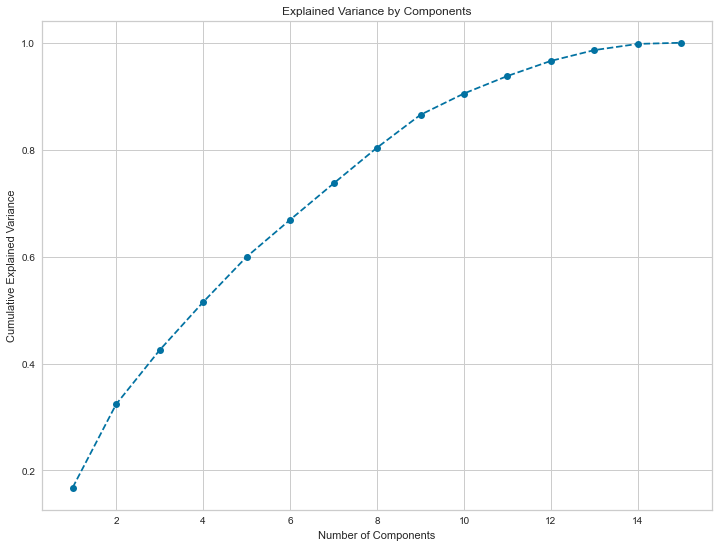

In [55]:
plt.figure(figsize = (12,9))
plt.plot(range(1,16), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [56]:
pca = PCA(n_components = 8)
pca.fit(df_std)
pca.components_

array([[ 0.11677556,  0.32603374,  0.32619979,  0.38412394,  0.37877185,
        -0.00342498, -0.28432352,  0.261167  ,  0.21736129, -0.0077294 ,
        -0.11544016, -0.34584898,  0.38166052, -0.08292353, -0.0282022 ],
       [ 0.09068819,  0.1253917 ,  0.25746862,  0.39402222, -0.32761129,
         0.00713226, -0.31462759,  0.24408041,  0.19584718, -0.00285496,
         0.13343798,  0.45699351, -0.464089  ,  0.08436248,  0.0324734 ],
       [-0.1474895 , -0.26077395, -0.38446513,  0.00573937, -0.04016542,
        -0.0092542 ,  0.24562391,  0.56184539,  0.58842971, -0.12764036,
         0.01455154, -0.06338865,  0.05664816,  0.04651186,  0.11204178],
       [-0.21564299,  0.51205337, -0.01309329, -0.15377748,  0.05023698,
        -0.03687945,  0.23357493,  0.05060221,  0.06739633, -0.13652381,
        -0.69635401,  0.19216796, -0.18339299,  0.0950968 , -0.13705467],
       [ 0.62573941,  0.13227769,  0.05242306, -0.20782594,  0.07150245,
         0.13270869,  0.33012882,  0.13351012, 

In [57]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns,
              index = ['Component 1', 'Component 2', 'Component 3','Component 4','Component 5','Component 6',
                      'Component 7','Component 8'])
df_pca_comp

,new_diff,tot_spending,max_shipping,tot_order_item_count,installment_payment,del/rev_mean,rev_count/tot_items_mean,Frequency,tenure,Recency,tot_ship/tot_spend,cash,credit_card,debit_card,voucher
Component 1,0.116776,0.326034,0.326200,0.384124,0.378772,-0.003425,-0.284324,0.261167,0.217361,-0.007729,-0.115440,-0.345849,0.381661,-0.082924,-0.028202
Component 2,0.090688,0.125392,0.257469,0.394022,-0.327611,0.007132,-0.314628,0.244080,0.195847,-0.002855,0.133438,0.456994,-0.464089,0.084362,0.032473
Component 3,-0.147489,-0.260774,-0.384465,0.005739,-0.040165,-0.009254,0.245624,0.561845,0.588430,-0.127640,0.014552,-0.063389,0.056648,0.046512,0.112042
Component 4,-0.215643,0.512053,-0.013093,-0.153777,0.050237,-0.036879,0.233575,0.050602,0.067396,-0.136524,-0.696354,0.192168,-0.183393,0.095097,-0.137055
Component 5,0.625739,0.132278,0.052423,-0.207826,0.071502,0.132709,0.330129,0.133510,0.136283,0.564337,-0.022617,0.115281,-0.059973,-0.190072,0.070033
Component 6,0.206081,0.155851,0.208334,-0.122124,-0.092688,-0.136504,0.167216,-0.028653,-0.001407,-0.154117,0.093297,-0.262012,-0.042325,0.685539,0.496038
Component 7,-0.241183,0.061026,-0.102151,0.087567,-0.119378,0.338922,-0.144644,-0.050315,-0.083864,0.144767,-0.219892,-0.047911,-0.003241,-0.320382,0.765596
Component 8,-0.027301,-0.058709,-0.084675,0.058027,0.026449,0.836098,-0.077088,0.000988,-0.009634,0.113294,-0.046393,-0.077669,-0.005374,0.436641,-0.260327


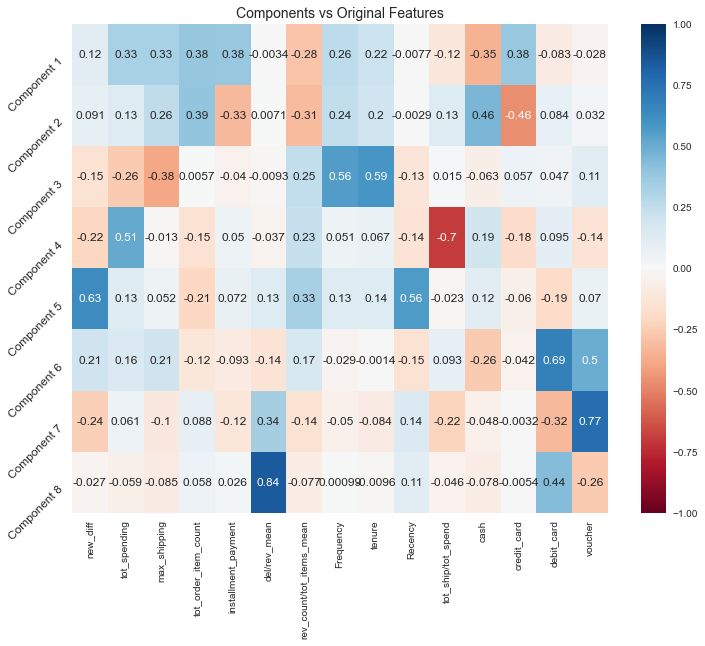

In [58]:
plt.figure(figsize=(12,9))
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([1, 2,3,4,5,6,7,8], 
           ['Component 1', 'Component 2', 'Component 3','Component 4','Component 5','Component 6','Component 7','Component 8'],
           rotation = 45,
           fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

In [60]:
pca.transform(df_std)
scores_pca = pca.transform(df_std) 

### KMeans++ Implementation

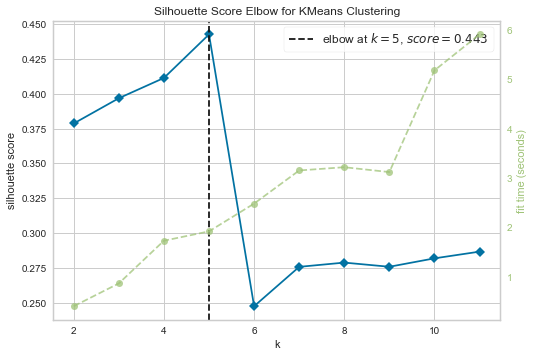

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [61]:
model = KMeans()
visualizer = KElbowVisualizer(model, metric = 'silhouette', k=(2,12))
visualizer.fit(scores_pca)
visualizer.show()
#this helps us to select the best number of clusters to our model, the best K=5. 
#We will run all models with K=5, for fair comparison 

In [68]:
kmeans_pca = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=5, random_state=42)

In [69]:
df_segm_pca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-8: ] = ['Component 1', 'Component 2', 'Component 3','Component 4','Component 5','Component 6','Component 7','Component 8']

df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
df_segm_pca_kmeans.head()

,new_diff,tot_spending,max_shipping,tot_order_item_count,installment_payment,del/rev_mean,rev_count/tot_items_mean,Frequency,tenure,Recency,tot_ship/tot_spend,cash,credit_card,debit_card,voucher,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Segment K-means PCA
0,15,72.20,13.29,1,1,1.0,1.0,1,1,351,0.1841,0,1,0,0,0.134744,-1.359183,0.229685,0.000866,-0.165375,-0.550747,0.102697,0.090305,3
1,18,284.50,19.94,2,1,2.5,1.0,2,146,345,0.1117,0,1,0,0,3.748865,1.704752,5.850932,1.187674,1.274950,-0.677589,-0.361771,0.181144,2
2,11,25.78,12.79,1,1,1.0,1.0,1,1,22,0.4960,0,1,0,0,-0.264653,-1.092621,0.670958,-1.451401,-1.752030,-0.115652,-0.659659,-0.243582,3
3,40,218.00,18.14,1,1,1.0,1.0,1,1,572,0.0832,0,1,0,0,0.831879,-1.075316,-0.639995,0.082321,2.543843,-0.117414,-0.177475,0.157663,3
4,24,31.75,11.85,1,0,10.0,1.0,1,1,263,0.3733,0,1,0,0,-0.757309,-0.440733,0.319636,-1.418118,0.053959,-0.079638,-0.044086,0.584872,3


In [70]:
#df_segm_pca_kmeans.to_csv('df_segm_pca_kmeans_cluster5.csv', index_label='ID')

In [71]:
# We calculate the means by segments.
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,new_diff,tot_spending,max_shipping,tot_order_item_count,installment_payment,del/rev_mean,rev_count/tot_items_mean,Frequency,tenure,Recency,tot_ship/tot_spend,cash,credit_card,debit_card,voucher,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8
Segment K-means PCA,,,,,,,,,,,,,,,,,,,,,,,
0,24.522787,376.088447,57.906033,2.533374,0.648765,2.656021,0.530967,1.054933,1.591683,232.374559,0.235363,0.142857,0.853614,0.004910,0.004450,2.760302,2.131854,-1.610033,-0.791040,-1.189250,-0.389378,0.315266,0.193262
1,23.275279,129.493003,20.072734,1.074633,0.000000,2.515357,0.983293,1.013515,1.130499,241.815332,0.225114,0.926187,0.001204,0.074250,0.000000,-2.021689,1.852673,-0.162406,0.582905,0.177640,-0.077480,-0.300224,0.100979
2,28.056464,323.417192,28.183945,2.697623,0.694651,2.384752,0.926686,2.236999,173.159733,181.511144,0.189876,0.234770,0.861813,0.024517,0.081724,4.514688,3.754465,6.805016,0.674350,1.339251,-0.105904,-0.627174,-0.040247
3,23.268937,151.534670,20.116595,1.038837,0.669698,2.416580,1.000065,1.011836,1.076384,235.918914,0.199586,0.000359,1.000000,0.000065,0.000000,0.240965,-0.873811,0.036064,-0.052922,0.021404,-0.074919,-0.145341,0.021901
4,23.748510,132.166141,20.599353,1.112932,0.191299,2.655319,0.977428,1.031585,1.747616,257.391836,0.232018,0.002980,0.598629,0.000000,1.000000,-0.559544,0.214517,0.623359,-0.942732,0.414191,2.588021,3.927133,-1.308812


In [72]:
#df_segm_pca_kmeans_freq.to_csv('clusters5.csv')

C:\Users\elfek\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


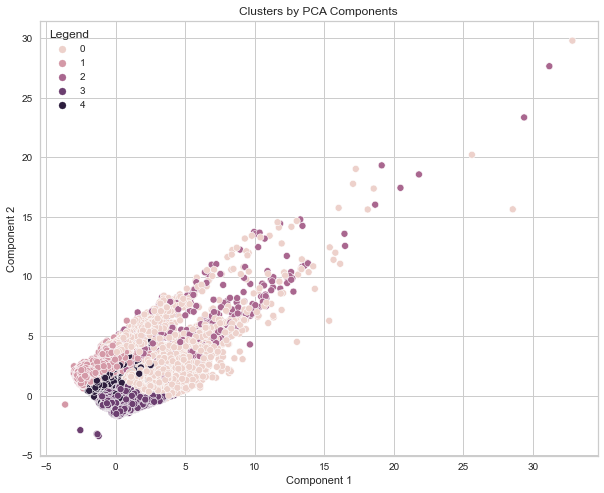

In [73]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA']
x_axis = df_segm_pca_kmeans['Component 1']
y_axis = df_segm_pca_kmeans['Component 2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'])
plt.title('Clusters by PCA Components')
plt.show()

---

### Gaussian Mixture Implementation  

In [42]:
del df['Segment K-means PCA']

In [74]:
gmm_pca = GaussianMixture(n_components = 5)
gmm_clusters_pca = gmm_pca.fit_predict(scores_pca)

In [75]:
gmm_clusters_pca

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [76]:
df_segm_pca_gmm = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_gmm.columns.values[-8: ] = ['Component 1', 'Component 2', 'Component 3','Component 4','Component 5','Component 6','Component 7','Component 8']

df_segm_pca_gmm['Segment GMM PCA'] = gmm_clusters_pca
df_segm_pca_gmm.head()

,new_diff,tot_spending,max_shipping,tot_order_item_count,installment_payment,del/rev_mean,rev_count/tot_items_mean,Frequency,tenure,Recency,tot_ship/tot_spend,cash,credit_card,debit_card,voucher,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Segment GMM PCA
0,15,72.20,13.29,1,1,1.0,1.0,1,1,351,0.1841,0,1,0,0,0.134744,-1.359183,0.229685,0.000866,-0.165375,-0.550747,0.102697,0.090305,0
1,18,284.50,19.94,2,1,2.5,1.0,2,146,345,0.1117,0,1,0,0,3.748865,1.704752,5.850932,1.187674,1.274950,-0.677589,-0.361771,0.181144,1
2,11,25.78,12.79,1,1,1.0,1.0,1,1,22,0.4960,0,1,0,0,-0.264653,-1.092621,0.670958,-1.451401,-1.752030,-0.115652,-0.659659,-0.243582,0
3,40,218.00,18.14,1,1,1.0,1.0,1,1,572,0.0832,0,1,0,0,0.831879,-1.075316,-0.639995,0.082321,2.543843,-0.117414,-0.177475,0.157663,0
4,24,31.75,11.85,1,0,10.0,1.0,1,1,263,0.3733,0,1,0,0,-0.757309,-0.440733,0.319636,-1.418118,0.053959,-0.079638,-0.044086,0.584872,0


In [77]:
# We calculate the means by segments
df_segm_pca_gmm_freq = df_segm_pca_gmm.groupby(['Segment GMM PCA']).mean()
df_segm_pca_gmm_freq

,new_diff,tot_spending,max_shipping,tot_order_item_count,installment_payment,del/rev_mean,rev_count/tot_items_mean,Frequency,tenure,Recency,tot_ship/tot_spend,cash,credit_card,debit_card,voucher,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8
Segment GMM PCA,,,,,,,,,,,,,,,,,,,,,,,
0,23.080011,126.340865,18.882673,1.000000,0.655367,2.051610,1.000000,1.000000,1.000000,234.653737,0.203000,0.000000,1.000000,0.000000,0.000000,0.130827,-0.930783,0.059436,-0.116667,-0.016618,-0.088422,-0.158565,-0.001086
1,24.973508,412.389709,45.573752,2.173948,0.674356,2.087503,0.767465,1.239648,20.237039,232.289045,0.196958,0.164330,0.847897,0.000000,0.019645,2.359819,1.589199,-0.115968,0.075951,-0.256199,-0.176630,0.087957,-0.007854
2,23.329591,109.047766,19.131158,1.052230,0.000000,2.145903,0.973885,1.000000,1.000000,246.534473,0.229614,1.000000,0.000000,0.000000,0.000000,-2.097178,1.860343,-0.221128,0.473307,0.290711,-0.558374,-0.125344,-0.188903
3,24.339836,206.712649,28.358338,1.253322,0.383376,11.602940,0.947374,1.045519,3.588634,224.667798,0.214687,0.095278,0.515974,0.403167,0.000848,-0.264379,0.703418,-0.034905,0.346808,-0.501678,2.129121,-0.854901,2.102098
4,23.647185,124.472153,20.429819,1.084282,0.185174,2.521378,0.975520,1.000000,1.000000,257.506921,0.232690,0.000000,0.597047,0.000000,1.000000,-0.638021,0.153948,0.532958,-0.967961,0.380441,2.591750,3.933065,-1.317578


C:\Users\elfek\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


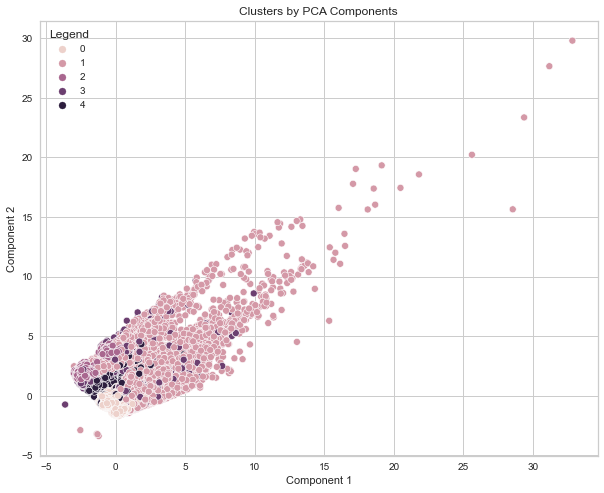

In [78]:
df_segm_pca_gmm['Legend'] = df_segm_pca_gmm['Segment GMM PCA']
x_axis = df_segm_pca_gmm['Component 1']
y_axis = df_segm_pca_gmm['Component 2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_gmm['Legend'])
plt.title('Clusters by PCA Components')
plt.show()

---

### BIRCH Implementation

In [ ]:
del df['Segment GMM PCA']

In [79]:
# Fitting Birch to data
clust_model = Birch(n_clusters=5)
clust_model.fit(scores_pca)

Birch(n_clusters=5)

In [80]:
# Evaluating model's performance
labels = clust_model.labels_

In [81]:
df_segm_pca_birch = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_birch.columns.values[-8: ] = ['Component 1', 'Component 2', 'Component 3','Component 4','Component 5','Component 6','Component 7','Component 8']

df_segm_pca_birch['Segment BIRCH PCA'] = labels
df_segm_pca_birch.head()

,new_diff,tot_spending,max_shipping,tot_order_item_count,installment_payment,del/rev_mean,rev_count/tot_items_mean,Frequency,tenure,Recency,tot_ship/tot_spend,cash,credit_card,debit_card,voucher,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Segment BIRCH PCA
0,15,72.20,13.29,1,1,1.0,1.0,1,1,351,0.1841,0,1,0,0,0.134744,-1.359183,0.229685,0.000866,-0.165375,-0.550747,0.102697,0.090305,0
1,18,284.50,19.94,2,1,2.5,1.0,2,146,345,0.1117,0,1,0,0,3.748865,1.704752,5.850932,1.187674,1.274950,-0.677589,-0.361771,0.181144,1
2,11,25.78,12.79,1,1,1.0,1.0,1,1,22,0.4960,0,1,0,0,-0.264653,-1.092621,0.670958,-1.451401,-1.752030,-0.115652,-0.659659,-0.243582,0
3,40,218.00,18.14,1,1,1.0,1.0,1,1,572,0.0832,0,1,0,0,0.831879,-1.075316,-0.639995,0.082321,2.543843,-0.117414,-0.177475,0.157663,0
4,24,31.75,11.85,1,0,10.0,1.0,1,1,263,0.3733,0,1,0,0,-0.757309,-0.440733,0.319636,-1.418118,0.053959,-0.079638,-0.044086,0.584872,0


In [82]:
# We calculate the means by segments.
df_segm_pca_birch_freq = df_segm_pca_birch.groupby(['Segment BIRCH PCA']).mean()
df_segm_pca_birch_freq

,new_diff,tot_spending,max_shipping,tot_order_item_count,installment_payment,del/rev_mean,rev_count/tot_items_mean,Frequency,tenure,Recency,tot_ship/tot_spend,cash,credit_card,debit_card,voucher,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8
Segment BIRCH PCA,,,,,,,,,,,,,,,,,,,,,,,
0,23.333723,154.619119,21.011777,1.038575,0.509470,2.195595,0.996476,1.001010,1.043466,236.954710,0.205729,0.196586,0.770690,0.017250,0.039816,-0.269246,-0.258643,-0.039571,0.072023,0.069280,0.062733,-0.030224,-0.036411
1,28.473684,328.960987,28.319079,2.769737,0.702632,2.652965,0.933698,2.360526,232.775000,160.415789,0.191411,0.278947,0.855263,0.010526,0.026316,5.204846,4.433819,8.488890,0.921747,1.704744,-0.347627,-1.067632,-0.040450
2,23.372806,259.822818,48.977427,2.619793,0.546127,2.326967,0.470658,1.012909,1.626850,238.139931,0.250297,0.245095,0.755766,0.000000,0.000516,2.300355,2.393541,-1.540748,-1.159003,-1.506467,-0.729990,0.419385,0.239766
3,25.766990,147.613883,19.735437,1.097087,0.504854,229.325243,0.974110,1.009709,1.000000,402.757282,0.197392,0.203883,0.776699,0.000000,0.048544,-0.241590,-0.024173,-0.400845,-0.946454,3.597566,-3.050531,7.296790,17.570218
4,26.574933,263.423349,25.710331,2.313600,0.634133,2.021411,0.939053,2.017600,33.955733,249.595200,0.200835,0.207467,0.819200,0.000000,0.103467,2.579738,2.126710,3.090319,0.112155,0.742084,-0.179823,0.057425,-0.095447


C:\Users\elfek\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


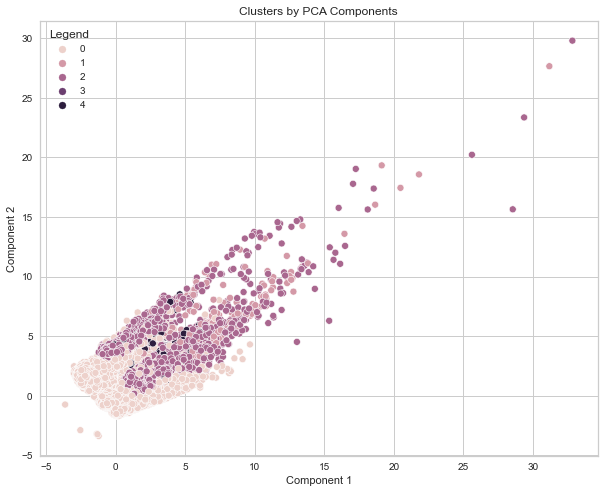

In [83]:
df_segm_pca_birch['Legend'] = df_segm_pca_birch['Segment BIRCH PCA']
x_axis = df_segm_pca_birch['Component 1']
y_axis = df_segm_pca_birch['Component 2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_birch['Legend'])
plt.title('Clusters by PCA Components')
plt.show()

### Comparing the silhouette scores for each model

In [84]:
def silhouette_method(df1,algo,y_pred):
  print('=================================================================================')
  print('Clustering ',algo," : silhouette score : ",silhouette_score(df1,y_pred) )


silhouette_method(scores_pca,' : KMeans++_pca',kmeans_pca.labels_)
silhouette_method(scores_pca,' : GMM_pca',gmm_clusters_pca)
silhouette_method(scores_pca,' : BIRCH_pca',labels)
print('=================================================================================')

Clustering   : KMeans++_pca  : silhouette score :  0.4426569994264603
Clustering   : GMM_pca  : silhouette score :  0.39106239637145135
Clustering   : BIRCH_pca  : silhouette score :  0.4079401826082869


---

## Merging Raw & df_segm_pca_kmeans to then visualize of PowerBI

In [86]:
raw = raw.reset_index()

In [87]:
raw

,customer_unique_id,new_diff,customer_autonomous_community,customer_city,payment_method,transaction_value,payment_method_sequence_id,og_cat_combined,new_cat_combined,tot_spending,max_shipping,tot_order_item_count,installment_payment,del/rev_mean,rev_count/tot_items_mean,Frequency,tenure,Recency,tot_ship/tot_spend
0,871766c5855e863f6eccc05f988b23cb,15,cataluna,tarragona,credit_card,72.20,1.0,comics,books,72.20,13.29,1,1,1.0,1.0,1,1,351,0.1841
1,eb28e67c4c0b83846050ddfb8a35d051,18,andalucia,cadiz,credit_card,284.50,1.0,"pet supplies,computer accessories","pets,computers & phones",284.50,19.94,2,1,2.5,1.0,2,146,345,0.1117
2,af861d436cfc08b2c2ddefd0ba074622,11,andalucia,cadiz,credit_card,25.78,1.0,fragrance,beauty & personal care,25.78,12.79,1,1,1.0,1.0,1,1,22,0.4960
3,64b576fb70d441e8f1b2d7d446e483c5,40,andalucia,cordoba,credit_card,218.00,1.0,lawn garden,garden,218.00,18.14,1,1,1.0,1.0,1,1,572,0.0832
4,635d9ac1680f03288e72ada3a1035803,24,andalucia,cadiz,credit_card,31.75,1.0,cell phones,computers & phones,31.75,11.85,1,0,10.0,1.0,1,1,263,0.3733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90746,ecc3d4eb9b17d2f0865d21f2abecc51c,33,comunidad de madrid,getafe,credit_card,139.90,1.0,tools home improvement,home & kitchen,139.90,20.03,1,1,3.0,1.0,1,1,72,0.1432
90747,0da9fe112eae0c74d3ba1fe16de0988b,17,galicia,coruna,cash,386.50,1.0,computer accessories,computers & phones,386.50,36.53,1,0,1.0,1.0,1,1,47,0.0945
90748,cd79b407828f02fdbba457111c38e4c4,17,comunidad de madrid,madrid,credit_card,116.90,1.0,sport outdoors,sport,116.90,16.95,1,1,1.0,1.0,1,1,310,0.1450
90749,eb803377c9315b564bdedad672039306,10,andalucia,sevilla,credit_card,64.70,1.0,computer accessories,computers & phones,64.70,8.72,1,1,1.0,1.0,1,1,380,0.1348


In [88]:
raw = pd.read_csv('C:/Users/elfek/Desktop/NTT/clean/raw.csv')
df_segm = pd.read_csv('C:/Users/elfek/Desktop/NTT/clean/df_segm_pca_kmeans_cluster5.csv')

In [89]:
df_with_clusters = pd.merge(df_segm[['ID','Segment K-means PCA']], raw, on ='ID', how='right')

In [211]:
#df_with_clusters.to_csv('df_with_clusters5.csv',index=False)